In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from poly_classifier import MNIST_PolyL3

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
len(dataset)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [3]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [5]:
input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
loss_fn = F.cross_entropy

In [8]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

NameError: name 'outputs' is not defined

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
class MNIST_PolyL3(nn.Module):
    def __init__(self, d, k, o):
        super(MNIST_PolyL3, self).__init__()
        
        self.layer_U1 = nn.Linear(d, k, bias=False)
        self.layer_U2 = nn.Linear(d, k, bias=False)
        self.layer_U3 = nn.Linear(d, k, bias=False)
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        x1 = self.layer_U1(z)
        x2 = self.layer_U2(z)*x1 + x1 
        x3 = self.layer_U3(z)*x2 + x2 
        x = self.layer_C(x3)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    


In [ ]:
rank = 20

model = MNIST_PolyL3(input_size, rank, num_classes)

In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.0840, val_acc: 0.4337
Epoch [1], val_loss: 1.7129, val_acc: 0.5981
Epoch [2], val_loss: 1.1967, val_acc: 0.7343
Epoch [3], val_loss: 0.8483, val_acc: 0.7997
Epoch [4], val_loss: 0.6836, val_acc: 0.8303


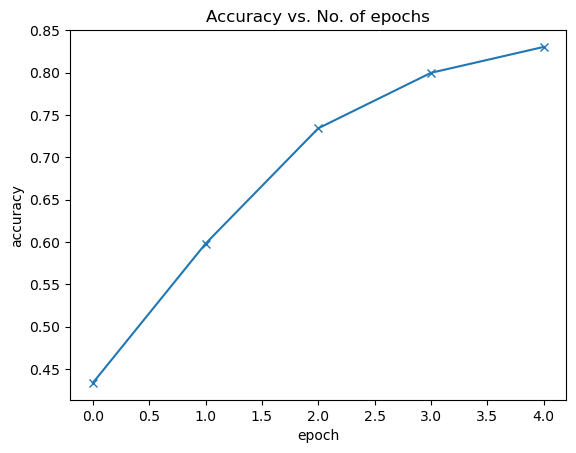

In [ ]:
history =  history1 
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


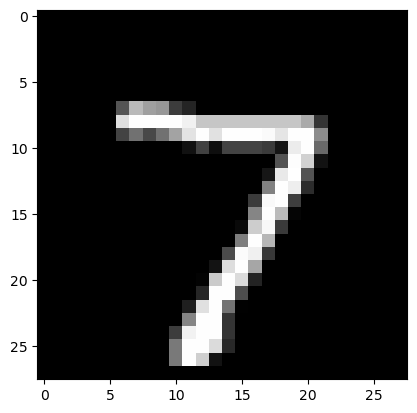

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6403375864028931, 'val_acc': 0.837597668170929}

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')